In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

## DATA PREPARATION

In [3]:
regs = pd.read_csv('/home/tomi/classification/all_regs.txt', delimiter = ' ', names = ['day', 'my_date', 'my_time','user_id','event_type','birth_year','phone_type', 'location','source'])

In [4]:
free_tree = pd.read_csv('/home/tomi/classification/all_free.txt', delimiter = ' ', names = ['day', 'my_date', 'user_id', 'event_type'])

In [5]:
super_tree = pd.read_csv('/home/tomi/classification/all_super.txt', delimiter = ' ', names = ['day', 'my_date', 'user_id', 'event_type'])

In [6]:
free_users = free_tree.groupby('user_id').count()[['event_type']].reset_index()

In [7]:
super_users = super_tree.groupby('user_id').count()[['event_type']].reset_index()

In [8]:
big_table = regs.merge(free_users, how = 'outer', on = 'user_id').merge(super_users, how = 'outer', on = 'user_id')

In [9]:
big_table.head()

,day,my_date,my_time,user_id,event_type_x,birth_year,phone_type,location,source,event_type_y,event_type
0,day_1,2017-12-01,00:32:11,1000001,registration,1983,android,sweden,invite_a_friend,5.0,NaN
1,day_1,2017-12-01,00:55:42,1000002,registration,1986,ios,united_states,invite_a_friend,4.0,NaN
2,day_1,2017-12-01,01:05:20,1000003,registration,1989,error,sweden,invite_a_friend,37.0,NaN
3,day_1,2017-12-01,01:23:24,1000004,registration,1994,error,germany,invite_a_friend,NaN,NaN
4,day_1,2017-12-01,01:24:16,1000005,registration,1986,ios,united_states,invite_a_friend,6.0,NaN


In [10]:
big_table = big_table[['user_id', 'phone_type', 'source', 'event_type_y', 'event_type']]

In [11]:
big_table.columns = ['user_id', 'phone_type', 'source', 'free', 'super']

In [12]:
big_table = big_table.fillna(value = 0)

In [13]:
big_table.head()

,user_id,phone_type,source,free,super
0,1000001,android,invite_a_friend,5.0,0.0
1,1000002,ios,invite_a_friend,4.0,0.0
2,1000003,error,invite_a_friend,37.0,0.0
3,1000004,error,invite_a_friend,0.0,0.0
4,1000005,ios,invite_a_friend,6.0,0.0


## VISUALIZATION

In [14]:
android = big_table[big_table.phone_type == 'android'].reset_index()
ios = big_table[big_table.phone_type == 'ios'].reset_index()

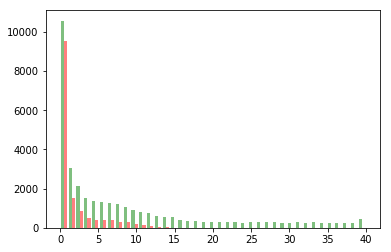

In [15]:
bins = np.linspace(0, 40, 40)
x = android['free']
y = ios['free']
data = [x,y]
plt.hist(data, bins, alpha = 0.5, color = ['g','r'])
plt.show()

In [16]:
x = android['super']
y = ios['super']

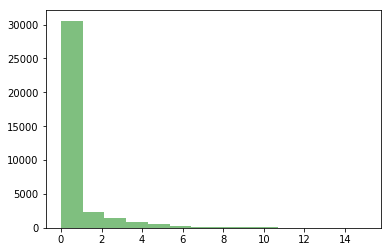

In [17]:
bins = np.linspace(0, 15, 15)
plt.hist(x, bins, alpha=0.5,color='green')
plt.show()

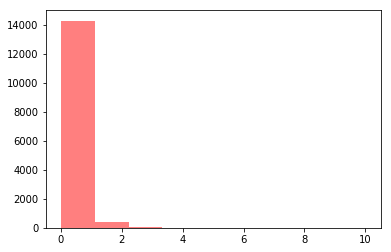

In [18]:
bins = np.linspace(0, 10, 10)
plt.hist(y, bins, alpha=0.5,color='red')
plt.show()

## MACHINE LEARNING

In [19]:
unknown_values = big_table[big_table.phone_type == 'error']
known_values = big_table[big_table.phone_type != 'error']

In [ ]:
phone_type_dictionary = {'ios': 0, 'android': 1}
source_dictionary = {'invite_a_friend': 0, 'google': 1, 'article': 2, 'paid': 3}
known_values['phone_type'] = known_values['phone_type'].map(phone_type_dictionary)
known_values['source'] = known_values['source'].map(source_dictionary)

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
x = known_values[['free', 'super', 'source']]
y = known_values['phone_type']

In [23]:
model = RandomForestClassifier(n_estimators = 100)
model = model.fit(x, y)

In [ ]:
unknown_values['source'] = unknown_values['source'].map(source_dictionary)

In [25]:
sample_user = [1, 6, 0]
model.predict([sample_user])

array([1])

In [27]:
for index, row in unknown_values.head(10).iterrows():
    print(model.predict([[row['free'], row['super'], row['source']]]))

[1]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]


## VALIDATION

In [28]:
phone_classification = []
for index, row in unknown_values.head(5000).iterrows():
    phone_classification.append(int(model.predict([[row['free'], row['super'], row['source']]])))

In [29]:
phone_classification.count(1), phone_classification.count(0)

(4511, 489)

In [30]:
classified_values = []
for index, row in known_values.head(5000).iterrows():
    classified_values.append(int(model.predict([[row['free'], row['super'], row['source']]])))

In [31]:
real_values = list(known_values.phone_type)

In [32]:
right = 0
wrong = 0
for i in range(0,5000):
    if classified_values[i] == real_values[i]:
        right = right + 1
    else:
        wrong = wrong + 1

In [33]:
right / (wrong + right)

0.7266